In [9]:
!pip install -q lightgbm

In [10]:
import cv2
import numpy as np
import pandas as pd
import joblib
import json
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb

# Verify installations
print(f"✓ OpenCV: {cv2.__version__}")
print(f"✓ NumPy: {np.__version__}")
print(f"✓ Pandas: {pd.__version__}")
print(f"✓ scikit-learn: {joblib.__version__}")
print(f"✓ LightGBM: {lgb.__version__}")

✓ OpenCV: 4.12.0
✓ NumPy: 1.26.4
✓ Pandas: 2.2.3
✓ scikit-learn: 1.5.2
✓ LightGBM: 4.6.0


In [11]:
from pathlib import Path
import zipfile

# IMPORTANT: Replace with YOUR dataset name
DATASET_NAME = "human-activity-recognition-video-dataset"  # ← CHANGE THIS!

# Find dataset
DATASET_PATH = Path(f"/kaggle/input/{DATASET_NAME}")

if not DATASET_PATH.exists():
    print("❌ Dataset not found!")
    print("\n📁 Available datasets:")
    for item in Path("/kaggle/input").iterdir():
        print(f"  - {item.name}")
    print("\n💡 Update DATASET_NAME variable above")
    raise FileNotFoundError("Dataset not found")

print(f"✓ Dataset found: {DATASET_PATH}")

# Check for zip files to extract
zip_files = list(DATASET_PATH.rglob("*.zip"))
if zip_files:
    zip_path = zip_files[0]
    print(f"\n📦 Extracting: {zip_path.name}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall("/kaggle/working/")

    # Update path to extracted folder (pick the most likely candidate)
    extracted_root = Path("/kaggle/working")
    subdirs = [d for d in extracted_root.iterdir() if d.is_dir()]
    # prefer a subdir whose name contains the dataset name, otherwise pick the first dir
    chosen = None
    for d in subdirs:
        if DATASET_NAME.lower() in d.name.lower():
            chosen = d
            break
    if chosen is None and subdirs:
        chosen = subdirs[0]

    if chosen:
        DATASET_PATH = chosen
        print(f"✓ Extracted to: {DATASET_PATH}")
    else:
        print("⚠️ Extraction done but no subfolder found under /kaggle/working/. Using /kaggle/working/ as dataset path.")
        DATASET_PATH = extracted_root

# List dataset structure
print(f"\n📁 Dataset structure (top-level):")
for item in sorted(DATASET_PATH.iterdir()):
    if item.is_dir():
        # count video files recursively and case-insensitive
        video_count = sum(
            1
            for p in item.rglob("*")
            if p.suffix.lower() in {".mp4", ".avi", ".mov", ".mkv"}
        )
        print(f"  📂 {item.name}/ ({video_count} videos)")
    else:
        # show files at top-level
        print(f"  📄 {item.name}")


✓ Dataset found: /kaggle/input/human-activity-recognition-video-dataset

📁 Dataset structure (top-level):
  📂 Human Activity Recognition - Video Dataset/ (1113 videos)


In [12]:
from pathlib import Path

# Update this to your actual dataset root path
DATASET_PATH = Path("/kaggle/input/human-activity-recognition-video-dataset/Human Activity Recognition - Video Dataset")

# Find all action classes (folders containing at least one video)
classes = []
for item in sorted(DATASET_PATH.iterdir()):
    if item.is_dir():
        # Look for common video extensions
        videos = list(item.glob("*.mp4")) + list(item.glob("*.avi")) + list(item.glob("*.mov"))
        if videos:
            classes.append(item.name)

if not classes:
    raise ValueError("No class folders with videos found!")

print(f"{'='*60}")
print(f"Found {len(classes)} classes:")
for cls in classes:
    print(f"  • {cls}")
print(f"{'='*60}\n")

# Count videos per class
total_videos = 0
print("Videos per class:")
print("-" * 40)

for cls in classes:
    class_path = DATASET_PATH / cls
    videos = (
        list(class_path.glob("*.mp4")) +
        list(class_path.glob("*.avi")) +
        list(class_path.glob("*.mov")) +
        list(class_path.glob("*.MOV")) +  # sometimes uppercase
        list(class_path.glob("*.MP4"))
    )
    count = len(videos)
    total_videos += count
    print(f"  {cls:35s}: {count:3d} videos")

print(f"\n{'='*60}")
print(f"  TOTAL: {total_videos} videos across {len(classes)} classes")
print(f"{'='*60}")

Found 7 classes:
  • Clapping
  • Meet and Split
  • Sitting
  • Standing Still
  • Walking
  • Walking While Reading Book
  • Walking While Using Phone

Videos per class:
----------------------------------------
  Clapping                           : 146 videos
  Meet and Split                     : 147 videos
  Sitting                            : 156 videos
  Standing Still                     : 174 videos
  Walking                            : 171 videos
  Walking While Reading Book         : 176 videos
  Walking While Using Phone          : 143 videos

  TOTAL: 1113 videos across 7 classes


In [13]:
def resample_video(video_path, target_fps=15):
    """Resample video to target FPS."""
    cap = cv2.VideoCapture(str(video_path))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps == 0 or original_fps > 120:
        original_fps = 30
    
    frame_interval = max(1, int(original_fps / target_fps))
    frames = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame_idx += 1
    
    cap.release()
    return frames


def detect_person_simple(frame, threshold=30):
    """Simple person detection using background subtraction."""
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (21, 21), 0)
    
    h, w = gray.shape
    center_region = blurred[h//4:3*h//4, w//4:3*w//4]
    bg_mean = np.mean(center_region)
    
    diff = cv2.absdiff(gray, np.uint8(bg_mean * np.ones_like(gray)))
    _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append((x, y, w, h))
    
    return boxes


def iou(box1, box2):
    """Calculate IoU between two boxes."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0


def track_iou_simple(detections_per_frame, iou_threshold=0.3):
    """Simple IoU-based tracking."""
    tracks = []
    next_track_id = 0
    results = []
    
    for frame_detections in detections_per_frame:
        frame_results = []
        matched_tracks = set()
        
        for det in frame_detections:
            best_iou = 0
            best_track_idx = -1
            
            for track_idx, (track_id, last_bbox) in enumerate(tracks):
                if track_idx in matched_tracks:
                    continue
                
                current_iou = iou(det, last_bbox)
                if current_iou > best_iou and current_iou > iou_threshold:
                    best_iou = current_iou
                    best_track_idx = track_idx
            
            if best_track_idx >= 0:
                track_id = tracks[best_track_idx][0]
                tracks[best_track_idx] = (track_id, det)
                matched_tracks.add(best_track_idx)
                frame_results.append((track_id, det))
            else:
                track_id = next_track_id
                next_track_id += 1
                tracks.append((track_id, det))
                frame_results.append((track_id, det))
        
        tracks = [t for i, t in enumerate(tracks) if i in matched_tracks]
        results.append(frame_results)
    
    return results


def extract_features(tracklet_frames, fps=15):
    """Extract features from tracklet."""
    if not tracklet_frames or not any(tracklet_frames):
        return {
            'center_dx_mean': 0, 'center_dx_std': 0,
            'center_dy_mean': 0, 'center_dy_std': 0,
            'vertical_range': 0,
            'area_mean': 0, 'area_std': 0,
            'aspect_ratio_mean': 0, 'aspect_ratio_std': 0,
            'detect_ratio': 0,
            'bbox_count': 0
        }
    
    # Extract primary track
    track_ids = []
    for frame_tracks in tracklet_frames:
        for track_id, _ in frame_tracks:
            track_ids.append(track_id)
    
    if not track_ids:
        return {
            'center_dx_mean': 0, 'center_dx_std': 0,
            'center_dy_mean': 0, 'center_dy_std': 0,
            'vertical_range': 0,
            'area_mean': 0, 'area_std': 0,
            'aspect_ratio_mean': 0, 'aspect_ratio_std': 0,
            'detect_ratio': 0,
            'bbox_count': 0
        }
    
    primary_track = max(set(track_ids), key=track_ids.count)
    
    # Collect boxes
    boxes = []
    centers = []
    areas = []
    aspect_ratios = []
    
    for frame_tracks in tracklet_frames:
        for track_id, (x, y, w, h) in frame_tracks:
            if track_id == primary_track:
                boxes.append((x, y, w, h))
                centers.append((x + w/2, y + h/2))
                areas.append(w * h)
                aspect_ratios.append(w / h if h > 0 else 1.0)
                break
    
    # Calculate features
    features = {}
    
    if len(centers) > 1:
        displacements_x = [centers[i+1][0] - centers[i][0] for i in range(len(centers)-1)]
        displacements_y = [centers[i+1][1] - centers[i][1] for i in range(len(centers)-1)]
        
        features['center_dx_mean'] = np.mean(displacements_x)
        features['center_dx_std'] = np.std(displacements_x)
        features['center_dy_mean'] = np.mean(displacements_y)
        features['center_dy_std'] = np.std(displacements_y)
    else:
        features['center_dx_mean'] = 0
        features['center_dx_std'] = 0
        features['center_dy_mean'] = 0
        features['center_dy_std'] = 0
    
    if centers:
        y_coords = [c[1] for c in centers]
        features['vertical_range'] = max(y_coords) - min(y_coords)
    else:
        features['vertical_range'] = 0
    
    features['area_mean'] = np.mean(areas) if areas else 0
    features['area_std'] = np.std(areas) if areas else 0
    features['aspect_ratio_mean'] = np.mean(aspect_ratios) if aspect_ratios else 1.0
    features['aspect_ratio_std'] = np.std(aspect_ratios) if aspect_ratios else 0
    features['detect_ratio'] = len(boxes) / len(tracklet_frames) if tracklet_frames else 0
    features['bbox_count'] = len(boxes)
    
    return features

print("✓ Feature extraction functions loaded")

✓ Feature extraction functions loaded


In [14]:
# Configuration
TARGET_FPS = 15
FEATURE_CACHE = Path("/kaggle/working/features_cache.json")

# Storage
all_features = []
all_labels = []
failed_videos = []

print(f"{'='*60}")
print(f"🎬 Starting Video Processing")
print(f"{'='*60}\n")

# Process each class
for class_idx, class_name in enumerate(classes):
    class_path = DATASET_PATH / class_name
    videos = list(class_path.glob("*.mp4")) + \
             list(class_path.glob("*.avi")) + \
             list(class_path.glob("*.mov"))
    
    print(f"[{class_idx+1}/{len(classes)}] Processing '{class_name}' ({len(videos)} videos)")
    
    for video_path in tqdm(videos, desc=f"  → {class_name}", ncols=80):
        try:
            # 1. Resample video
            frames = resample_video(video_path, TARGET_FPS)
            
            if len(frames) < 5:
                failed_videos.append((video_path.name, "Too few frames"))
                continue
            
            # 2. Detect persons
            detections = []
            for i in range(0, len(frames), 3):
                boxes = detect_person_simple(frames[i])
                detections.append(boxes)
            
            # Interpolate
            full_detections = []
            for i in range(len(frames)):
                idx = min(i // 3, len(detections) - 1)
                full_detections.append(detections[idx])
            
            # 3. Track
            tracks = track_iou_simple(full_detections)
            
            # 4. Extract features
            features = extract_features(tracks, fps=TARGET_FPS)
            
            # Store
            all_features.append(features)
            all_labels.append(class_name)
            
        except Exception as e:
            failed_videos.append((video_path.name, str(e)))
            continue
    
    print(f"  ✓ Complete\n")

# Save cache
cache_data = {
    'features': all_features,
    'labels': all_labels,
    'classes': classes,
    'failed_videos': failed_videos,
    'target_fps': TARGET_FPS
}

with open(FEATURE_CACHE, 'w') as f:
    json.dump(cache_data, f)

print(f"{'='*60}")
print(f"✅ Processing Complete!")
print(f"{'='*60}")
print(f"  Success: {len(all_features)} videos")
print(f"  Failed: {len(failed_videos)} videos")
print(f"{'='*60}\n")

🎬 Starting Video Processing

[1/7] Processing 'Clapping' (146 videos)


  → Clapping: 100%|███████████████████████████| 146/146 [06:48<00:00,  2.80s/it]


  ✓ Complete

[2/7] Processing 'Meet and Split' (147 videos)


  → Meet and Split: 100%|█████████████████████| 147/147 [06:34<00:00,  2.68s/it]


  ✓ Complete

[3/7] Processing 'Sitting' (156 videos)


  → Sitting: 100%|████████████████████████████| 156/156 [10:29<00:00,  4.04s/it]


  ✓ Complete

[4/7] Processing 'Standing Still' (174 videos)


  → Standing Still: 100%|█████████████████████| 174/174 [12:03<00:00,  4.16s/it]


  ✓ Complete

[5/7] Processing 'Walking' (171 videos)


  → Walking: 100%|████████████████████████████| 171/171 [08:18<00:00,  2.92s/it]


  ✓ Complete

[6/7] Processing 'Walking While Reading Book' (176 videos)


  → Walking While Reading Book: 100%|█████████| 176/176 [09:47<00:00,  3.34s/it]


  ✓ Complete

[7/7] Processing 'Walking While Using Phone' (143 videos)


  → Walking While Using Phone: 100%|██████████| 143/143 [08:37<00:00,  3.62s/it]

  ✓ Complete

✅ Processing Complete!
  Success: 1113 videos
  Failed: 0 videos



📊 Dataset Overview
  Total samples: 1113
  Features: 11
  Classes: 7

  Class distribution:
    Walking While Reading Book: 176 (15.8%)
    Standing Still      : 174 (15.6%)
    Walking             : 171 (15.4%)
    Sitting             : 156 (14.0%)
    Meet and Split      : 147 (13.2%)
    Clapping            : 146 (13.1%)
    Walking While Using Phone: 143 (12.8%)


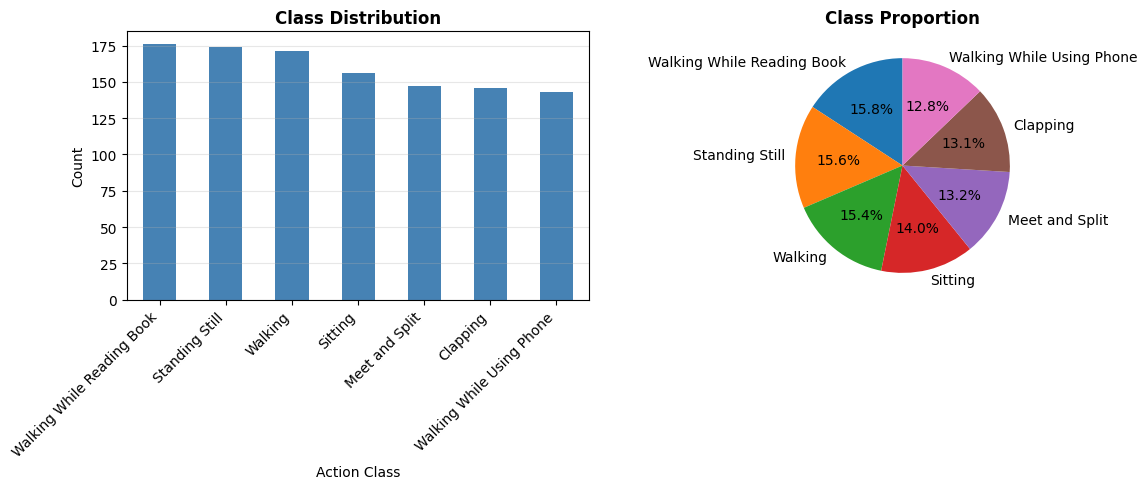


✓ Data prepared: X(1113, 11), y(1113,)


In [20]:
# Load cached features
with open(FEATURE_CACHE, 'r') as f:
    cache_data = json.load(f)

all_features = cache_data['features']
all_labels = cache_data['labels']

# Convert to DataFrame
df = pd.DataFrame(all_features)
df['label'] = all_labels

print(f"{'='*60}")
print(f"📊 Dataset Overview")
print(f"{'='*60}")
print(f"  Total samples: {len(df)}")
print(f"  Features: {len(df.columns) - 1}")
print(f"  Classes: {len(df['label'].unique())}")
print(f"\n  Class distribution:")
for label, count in df['label'].value_counts().items():
    print(f"    {label:20s}: {count:3d} ({count/len(df)*100:.1f}%)")

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Class Distribution', fontweight='bold')
plt.xlabel('Action Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Class Proportion', fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Prepare data
feature_columns = [col for col in df.columns if col != 'label']
X = df[feature_columns].values
y = df['label'].values

print(f"\n✓ Data prepared: X{X.shape}, y{y.shape}")

In [21]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"📋 Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i} → {label}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📊 Split: {len(X_train)} train, {len(X_test)} test")

# Train LightGBM
print(f"\n{'='*60}")
print(f"🚀 Training LightGBM Classifier")
print(f"{'='*60}\n")

classifier = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

classifier.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='multi_logloss',
)

# Evaluate
y_pred = classifier.predict(X_test_scaled)
y_pred_proba = classifier.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*60}")
print(f"🎯 Test Accuracy: {accuracy:.2%}")
print(f"{'='*60}\n")

📋 Label Encoding:
  0 → Clapping
  1 → Meet and Split
  2 → Sitting
  3 → Standing Still
  4 → Walking
  5 → Walking While Reading Book
  6 → Walking While Using Phone

📊 Split: 890 train, 223 test

🚀 Training LightGBM Classifier


🎯 Test Accuracy: 48.88%



📊 Classification Report:

                            precision    recall  f1-score   support

                  Clapping       0.41      0.38      0.39        29
            Meet and Split       0.40      0.33      0.36        30
                   Sitting       0.41      0.45      0.43        31
            Standing Still       0.52      0.69      0.59        35
                   Walking       0.50      0.35      0.41        34
Walking While Reading Book       0.57      0.60      0.58        35
 Walking While Using Phone       0.57      0.59      0.58        29

                  accuracy                           0.49       223
                 macro avg       0.48      0.48      0.48       223
              weighted avg       0.48      0.49      0.48       223



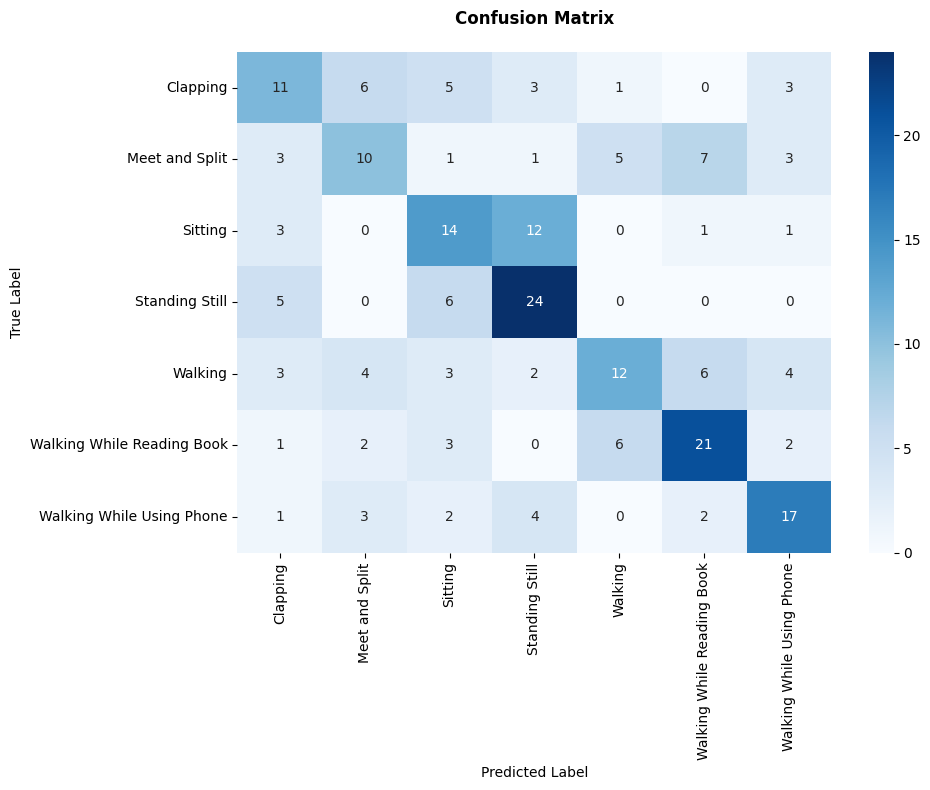


🔍 Top 10 Features:
          feature  importance
     detect_ratio       21148
aspect_ratio_mean        4224
        area_mean        4120
   center_dx_mean           0
    center_dx_std           0
   center_dy_mean           0
    center_dy_std           0
   vertical_range           0
         area_std           0
 aspect_ratio_std           0


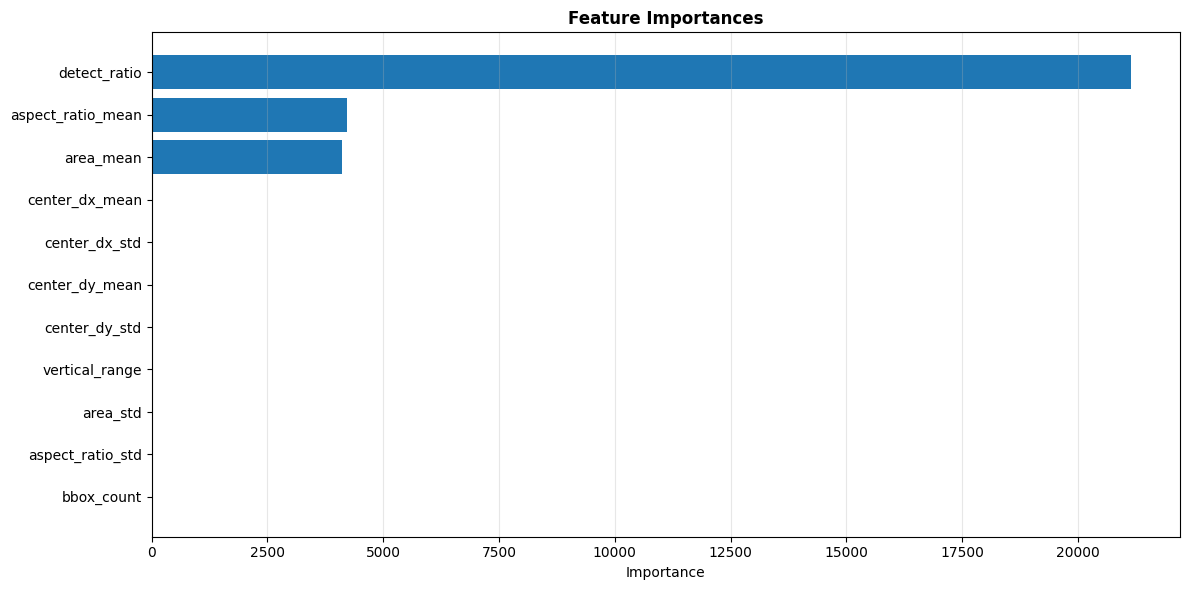

In [22]:
# Classification Report
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print(f"📊 Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix', fontweight='bold', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 Top 10 Features:")
print(importances.head(10).to_string(index=False))

plt.figure(figsize=(12, 6))
top_n = min(15, len(importances))
plt.barh(range(top_n), importances['importance'][:top_n])
plt.yticks(range(top_n), importances['feature'][:top_n])
plt.xlabel('Importance')
plt.title('Feature Importances', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Create artifacts directory
ARTIFACTS_DIR = Path("/kaggle/working/artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

print(f"💾 Saving artifacts...")

# Save files
joblib.dump(classifier, ARTIFACTS_DIR / "classifier.pkl")
joblib.dump(scaler, ARTIFACTS_DIR / "scaler.pkl")
joblib.dump(label_encoder, ARTIFACTS_DIR / "label_encoder.pkl")

# Metadata
meta = {
    'model_type': 'LGBMClassifier',
    'classes': label_encoder.classes_.tolist(),
    'feature_names': feature_columns,
    'n_features': len(feature_columns),
    'fps': TARGET_FPS,
    'trained_on': datetime.now().isoformat(),
    'test_accuracy': float(accuracy),
    'numpy_version': np.__version__,
    'pandas_version': pd.__version__,
    'lightgbm_version': lgb.__version__,
    'opencv_version': cv2.__version__
}

with open(ARTIFACTS_DIR / "meta.json", 'w') as f:
    json.dump(meta, f, indent=2)

# Label mapping
label_mapping = {int(i): label for i, label in enumerate(label_encoder.classes_)}
with open(ARTIFACTS_DIR / "label_mapping.json", 'w') as f:
    json.dump(label_mapping, f, indent=2)

# Requirements
requirements = f"""numpy=={np.__version__}
pandas=={pd.__version__}
scikit-learn==1.2.2
lightgbm=={lgb.__version__}
opencv-python=={cv2.__version__}
joblib==1.3.0
"""

with open(ARTIFACTS_DIR / "requirements.txt", 'w') as f:
    f.write(requirements)

# Create ZIP
!cd /kaggle/working && zip -r artifacts.zip artifacts/

print(f"\n{'='*60}")
print(f"✅ Artifacts Saved!")
print(f"{'='*60}")
print(f"📦 Download 'artifacts.zip' from Output tab")
print(f"{'='*60}")

💾 Saving artifacts...
updating: artifacts/ (stored 0%)
updating: artifacts/classifier.pkl (deflated 63%)
updating: artifacts/label_encoder.pkl (deflated 35%)
updating: artifacts/meta.json (deflated 51%)
updating: artifacts/scaler.pkl (deflated 18%)
updating: artifacts/requirements.txt (deflated 14%)
updating: artifacts/label_mapping.json (deflated 38%)

✅ Artifacts Saved!
📦 Download 'artifacts.zip' from Output tab


In [25]:
print("🧪 Testing model...\n")

# Load
test_classifier = joblib.load(ARTIFACTS_DIR / "classifier.pkl")
test_scaler = joblib.load(ARTIFACTS_DIR / "scaler.pkl")
test_label_encoder = joblib.load(ARTIFACTS_DIR / "label_encoder.pkl")

# Test prediction
test_features = {name: 0.0 for name in feature_columns}
test_features['detect_ratio'] = 0.9
test_features['bbox_count'] = 20
test_features['vertical_range'] = 40

X_test_sample = np.array([[test_features[name] for name in feature_columns]])
X_test_sample_scaled = test_scaler.transform(X_test_sample)

prediction = test_classifier.predict(X_test_sample_scaled)[0]
probabilities = test_classifier.predict_proba(X_test_sample_scaled)[0]
predicted_label = test_label_encoder.inverse_transform([prediction])[0]

print(f"Prediction: {predicted_label}")
print(f"Confidence: {probabilities[prediction]:.2%}")
print(f"\nAll probabilities:")
for i, label in enumerate(test_label_encoder.classes_):
    print(f"  {label:20s}: {probabilities[i]:.2%}")

print(f"\n✅ Model works! Ready for deployment!")

🧪 Testing model...

Prediction: Clapping
Confidence: 90.37%

All probabilities:
  Clapping            : 90.37%
  Meet and Split      : 0.62%
  Sitting             : 0.45%
  Standing Still      : 0.00%
  Walking             : 6.18%
  Walking While Reading Book: 2.38%
  Walking While Using Phone: 0.00%

✅ Model works! Ready for deployment!
